<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week13/RBF_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBF for reggression



In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

class RBFNetwork:
    def __init__(self, n_centers=10, beta=None, lr=0.01, epochs=1000, random_state=42):
        self.n_centers = n_centers
        self.beta = beta  # can be set later based on data
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
        self.centers = None
        self.weights = None

    def _rbf(self, x):
        # Compute RBF activations for input x (shape: (n_samples, 1))
        dists = cdist(x, self.centers)
        return np.exp(-self.beta * dists ** 2)

    def fit(self, X, y):
        # Initialize centers using KMeans
        kmeans = KMeans(n_clusters=self.n_centers, random_state=self.random_state).fit(X)
        self.centers = kmeans.cluster_centers_

        # Set beta if not defined
        if self.beta is None:
            d_max = np.max(cdist(self.centers, self.centers))
            self.beta = 1 / (2 * (d_max / np.sqrt(2 * self.n_centers))**2)

        # Initialize weights
        self.weights = np.random.randn(self.n_centers) * 0.1

        # SGD training
        for epoch in range(self.epochs):
            for xi, yi in zip(X, y):
                phi = self._rbf(xi.reshape(1, -1)).flatten()
                y_hat = np.dot(self.weights, phi)
                error = yi - y_hat
                self.weights += self.lr * error * phi

    def predict(self, X):
        Phi = self._rbf(X)
        return Phi @ self.weights

    def plot(self, X, y_true, show_basis=True):
        y_pred = self.predict(X)
        Phi = self._rbf(X)

        plt.figure(figsize=(12, 6))
        plt.plot(X, y_true, 'k--', label='Target function')
        plt.plot(X, y_pred, 'r-', lw=2, label='RBF network output')

        if show_basis:
            for i in range(self.n_centers):
                plt.plot(X, self.weights[i] * Phi[:, i], alpha=0.5, label=f'RBF {i+1}')

        plt.title("RBF Neural Network (NumPy)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.legend(fontsize=8, loc='upper right')
        plt.show()


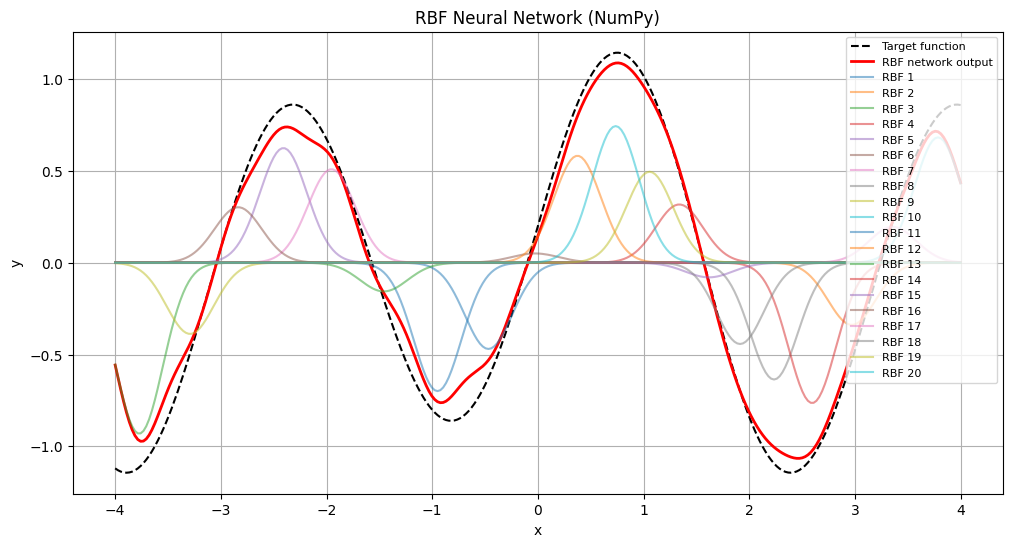

In [53]:
# Generate data
X = np.linspace(-4, 4, 300).reshape(-1, 1)
y = (np.sin(2 * X) + 0.5 * np.cos(3 * X) + 0.2 * X).ravel()
y = (np.sin(2 * X)+ 0.2 * np.cos(X)).ravel()
# Train and visualize
rbfnet = RBFNetwork(n_centers=20, epochs=100, lr=0.001, beta = 10)
rbfnet.fit(X, y)
rbfnet.plot(X, y)


# RBF for classification

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import OneHotEncoder

class RBFClassifier:
    def __init__(self, n_centers=10, beta=None, lr=0.05, epochs=1000, random_state=42):
        self.n_centers = n_centers
        self.beta = beta
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
        self.centers = None
        self.weights = None
        self.n_classes = None

    def _rbf(self, X):
        dists = cdist(X, self.centers)
        return np.exp(-self.beta * dists ** 2)

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        # --- One-hot encode labels ---
        y = np.array(y).reshape(-1, 1)
        enc = OneHotEncoder(sparse_output=False)
        Y = enc.fit_transform(y)
        self.n_classes = Y.shape[1]

        # --- Initialize centers using KMeans ---
        kmeans = KMeans(n_clusters=self.n_centers, random_state=self.random_state).fit(X)
        self.centers = kmeans.cluster_centers_

        # --- Beta heuristic ---
        if self.beta is None:
            d_max = np.max(cdist(self.centers, self.centers))
            self.beta = 1 / (2 * (d_max / np.sqrt(2 * self.n_centers)) ** 2)

        # --- Initialize weights (shape: [n_centers, n_classes]) ---
        self.weights = np.random.randn(self.n_centers, self.n_classes) * 0.1

        # --- SGD training ---
        for epoch in range(self.epochs):
            for xi, ti in zip(X, Y):
                phi = self._rbf(xi.reshape(1, -1))  # shape (1, n_centers)
                z = phi @ self.weights  # shape (1, n_classes)
                y_hat = self._softmax(z)  # shape (1, n_classes)
                error = ti - y_hat  # shape (1, n_classes)
                self.weights += self.lr * phi.T @ error  # gradient step

    def predict_proba(self, X):
        Phi = self._rbf(X)
        return self._softmax(Phi @ self.weights)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def plot(self, X, y_true):
        y_pred = self.predict(X)

        plt.figure(figsize=(8, 4))
        plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='Set1', s=40, edgecolor='k', label='Prediction')
        plt.title("RBF Classifier (Predicted Labels)")
        plt.grid(True)
        plt.show()


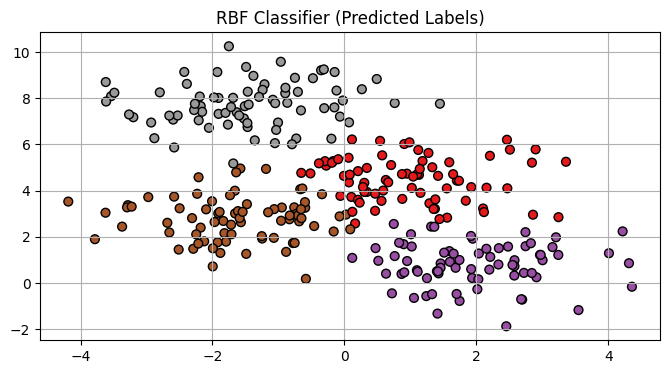

In [58]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=300, noise=0.15, random_state=0)
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
rbf_clf = RBFClassifier(n_centers=20, epochs=200)
rbf_clf.fit(X, y)
rbf_clf.plot(X, y)


In [59]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_rbf_neurons(rbf_clf, X, y):
    centers = rbf_clf.centers
    beta = rbf_clf.beta
    radius = np.sqrt(1 / (2 * beta))  # Gaussian stddev (influence zone)

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', s=30, edgecolor='k', label='Data')

    for center in centers:
        circle = Circle(center, radius, edgecolor='blue', facecolor='none', linestyle='--', alpha=0.5)
        plt.gca().add_patch(circle)
        plt.plot(center[0], center[1], 'bo')  # neuron center

    plt.title("RBF Neurons and Their Receptive Fields")
    plt.axis('equal')
    plt.grid(True)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()


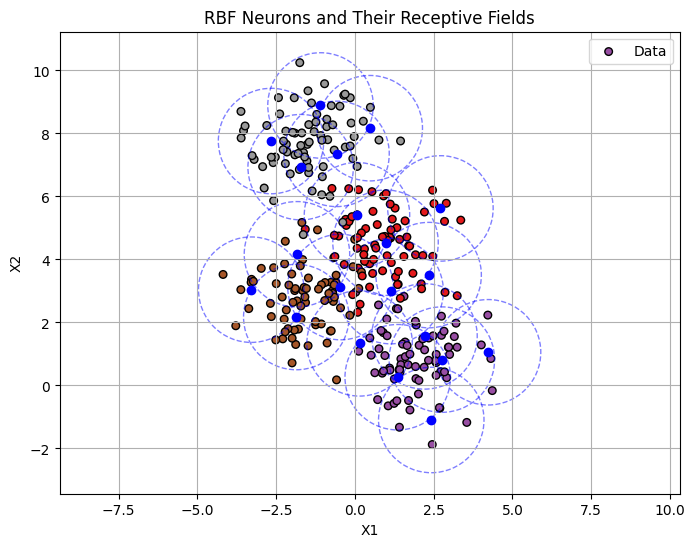

In [60]:
plot_rbf_neurons(rbf_clf, X, y)